<a href="https://colab.research.google.com/github/Expan75/team20-adverserial-artists/blob/dev-mnist/GAN_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q git+https://github.com/DeepTrackAI/deeplay.git
# %pip install deeplay
%pip install -q deeptrack --pre
%pip install -q multiprocess

import torch
from rich import print

# Define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))

print(f"Torch version: {torch.__version__}\nCUDA version: {torch.version.cuda}\nDevice: {device}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 

Torch version: 2.2.1+cu121
CUDA version: 12.1
Device: cuda:0

In [2]:
import deeplay as dl
import deeptrack as dt
import torch.nn as nn
import torchvision
import multiprocess as mp
from pathlib import Path
import os

In [3]:
DATA_PATH: Path = Path.cwd() / "data"
DATA_PATH.mkdir(exist_ok=True)
os.environ["DATA_PATH"] = str(DATA_PATH)

mnist_dataset_path: Path = DATA_PATH / "MNIST_dataset" / "mnist"

if not mnist_dataset_path.exists():
    !cd $DATA_PATH && git clone https://github.com/DeepTrackAI/MNIST_dataset

train_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "train"),
)
test_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "test"),
)
files = dt.sources.Join(train_files, test_files)

Cloning into 'MNIST_dataset'...
remote: Enumerating objects: 70019, done.
remote: Counting objects: 100% (70019/70019), done.
remote: Compressing objects: 100% (70014/70014), done.
remote: Total 70019 (delta 4), reused 70008 (delta 2), pack-reused 0
Receiving objects: 100% (70019/70019), 37.33 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (70003/70003), done.


In [4]:
image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

label_pipeline = (
    dt.Value(files.label_name[0])
    >> int
)

In [5]:
train_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=train_files)
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=test_files)

train_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=True)
test_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
from kornia.contrib import extract_tensor_patches, combine_tensor_patches
import numpy as np


class Generator(dl.UNet2d):
    def __init__(self, *args, **kwargs):
        self.patch_size = kwargs["channels"][0]
        super().__init__(*args, **kwargs)

    def forward(self, input):
        _, _, height, width = input.shape
        input.requires_grad_()

        if any(l < self.patch_size for l in (height, width)):
            raise ValueError(
                f"Image ({height}x{width}) is smaller than kernel size ({self.patch_size}x{self.patch_size})"
            )

        stride = [np.gcd(height, self.patch_size), np.gcd(width, self.patch_size)]
        input_patches = extract_tensor_patches(input=input, window_size=self.patch_size, stride=stride).movedim(1, 0)

        output_patches = torch.vmap(super().forward)(input_patches).movedim(0, 1)

        output = combine_tensor_patches(
            patches=output_patches, original_size=(height, width), window_size=self.patch_size, stride=stride
        )

        return output


generator_model = Generator(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
    skip=dl.Cat()
)
# print(generator_model)

In [7]:
class Discriminator(dl.DeeplayModule):
    def __init__(
            self,
            in_channels,
            hidden_channels_cnn,
            hidden_channels_mlp,
            out_channels_cnn,
            out_features
        ):
        super().__init__()

        self.cnn = dl.ConvolutionalNeuralNetwork(
            in_channels=in_channels,
            hidden_channels=hidden_channels_cnn,
            out_channels=out_channels_cnn,
            pool=nn.MaxPool2d(kernel_size=2),
            out_activation=nn.ReLU,
        )

        self.pool = dl.Layer(nn.MaxPool2d, kernel_size=2)
        self.flatten = dl.Layer(nn.Flatten)

        self.dense = dl.MultiLayerPerceptron(
            in_features=out_channels_cnn,
            hidden_features=hidden_channels_mlp,
            out_features=out_features,
            out_activation=nn.Identity,
        )
        self.dense[..., "layer#0"].configure(nn.LazyLinear)
        # self.dense[..., "activation#-1"] = dl.Layer[nn.Softmax]


    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(self.pool(x))
        x = self.dense(x)

        return torch.sigmoid(x)

discriminator_1 = Discriminator(
    in_channels=1,
    hidden_channels_cnn=[16, 32, 64],
    hidden_channels_mlp=[64, 32],
    out_channels_cnn=64,
    out_features=1
)
discriminator_2 = Discriminator(
    in_channels=1,
    hidden_channels_cnn=[16, 32, 64],
    hidden_channels_mlp=[64, 32],
    out_channels_cnn=64,
    out_features=10
)
# discriminator_2.dense[..., "activation#-1"] = dl.Layer[nn.Softmax]
# print(discriminator_1)
# print(discriminator_2)

In [11]:
import matplotlib.pyplot as plt
from kornia.utils import tensor_to_image
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from contextlib import contextmanager


class GAN(dl.Application):
    def __init__(self, generator, discriminator_1=None, discriminator_2=None, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator_1 = discriminator_1
        self.discriminator_2 = discriminator_2

        if not discriminator_1 and not discriminator_2:
            raise ValueError("The GAN must have at least one discriminator")

        self.automatic_optimization = False

    def configure_optimizers(self):
        optimizers, schedulers = [], []

        generator_optimizer = self.create_optimizer_with_params(
            dl.Adam(lr=1e-4), self.generator.parameters()
        )
        optimizers.append(generator_optimizer)

        if self.discriminator_1:
            discriminator_1_optimizer = self.create_optimizer_with_params(
                dl.Adam(lr=1e-5), self.discriminator_1.parameters()
            )
            optimizers.append(discriminator_1_optimizer)
            discriminator_1_scheduler = StepLR(discriminator_1_optimizer, step_size=1,gamma=0.8)
            schedulers.append(discriminator_1_scheduler)

        if self.discriminator_2:
            discriminator_2_optimizer = self.create_optimizer_with_params(
                dl.Adam(lr=1e-4), self.discriminator_2.parameters()
            )
            optimizers.append(discriminator_2_optimizer)

        return optimizers, schedulers

    def forward(self, batch):
        return self.generator(batch)

    def adversarial_loss_1(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target)

    def adversarial_loss_2(self, input, target):
        return torch.sum((input - target) ** 2.0) / target.shape[0]

    def plot_training_images(self, batch_tensor, n_plots, name=None):
        fig, axs = plt.subplots(1, n_plots, figsize=((10, n_plots * 10)))

        for i_ax, ax, img in zip(range(n_plots), axs.ravel(), [tensor_to_image(o) for o in batch_tensor[:n_plots].clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")

            if name and i_ax == 0:
                ax.set_ylabel(name)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_axis_off()


        plt.show()

    def training_step(self, batch, batch_idx):
        ####################
        # Prepare training #
        ####################

        self.train()

        # Prepare inputs and targets

        input, target = batch

        fake_label = torch.zeros(input.size(0), 1).type_as(input)

        # Get optimizers and schedulers

        optimizers = self.optimizers()
        gen_opt = optimizers[0]

        if self.discriminator_1 and self.discriminator_2:
            disc_1_opt = optimizers[1]
            disc_1_sched = self.lr_schedulers()
            disc_2_opt = optimizers[2]
        elif self.discriminator_1 and not self.discriminator_2:
            disc_1_opt = optimizers[1]
            disc_1_sched = self.lr_schedulers()
        else:
            disc_2_opt = optimizers[1]

        ###################
        # Train generator #
        ###################

        self.toggle_optimizer(gen_opt)

        # Feed input into generator
        gen_output = self(input)

        if self.discriminator_1:
            # Feed generated image to discriminator 1
            disc_1_output_fake = self.discriminator_1(gen_output)

            # Prepare target
            real_label = torch.ones(input.size(0), 1).type_as(input)

            # Compute loss
            gen_loss_disc_1 = self.adversarial_loss_1(disc_1_output_fake, real_label)
            self.log("gen_loss_disc_1", gen_loss_disc_1, prog_bar=True)
        else:
            gen_loss_disc_1 = 0

        if self.discriminator_2:
            # Feed generated image to discriminator 2
            disc_2_output_fake = F.softmax(self.discriminator_2(gen_output), dim=1)

            # Prepare target
            target_oh = F.one_hot(target, num_classes=10)
            fake_target = torch.zeros_like(disc_2_output_fake)

            # Compute loss
            gen_loss_disc_2 = self.adversarial_loss_2(disc_2_output_fake * target_oh.squeeze(1), fake_target)
            self.log("gen_loss_disc_2", gen_loss_disc_2, prog_bar=True)
        else:
            gen_loss_disc_2 = 0


        # Compute norm of pixel difference between input and generator output
        diff = input - gen_output
        norm = torch.norm(diff, dim=(2,3))

        # Compute loss for norm
        gen_loss_norm = self.adversarial_loss_1(norm, fake_label)
        self.log("gen_loss_norm", gen_loss_norm, prog_bar=True)

        # Compute total generator loss
        gen_loss = 100 * gen_loss_disc_2 + gen_loss_disc_1 + 0.5 * gen_loss_norm
        self.log("gen_loss", gen_loss, prog_bar=True)

        # Run optimization
        self.manual_backward(gen_loss)
        gen_opt.step()
        gen_opt.zero_grad()
        self.untoggle_optimizer(gen_opt)

        ###############################
        # Print output once per epoch #
        ###############################

        if batch_idx == 0:
            print(f"Epoch {self.current_epoch}")
            n_plots = 5

            self.plot_training_images(input, n_plots, "Input image")
            self.plot_training_images(gen_output, n_plots, "Generator output")
            self.plot_training_images(torch.abs(diff), n_plots, "Absolute difference")

            print("Norm\n", norm[:5].transpose(0,1))

            if self.discriminator_1:
                print("Discriminator 1 guess\n", disc_1_output_fake[:5].transpose(0,1))

            if self.discriminator_2:
                print("Discriminator 2 guess (fake)\n", torch.argmax(disc_2_output_fake,dim=1)[:5].unsqueeze(-1).transpose(0,1))

        #########################
        # Train discriminator 1 #
        #########################

        if self.discriminator_1:
            self.toggle_optimizer(disc_1_opt)

            # Feed input into generator
            gen_output = self(input)

            # Feed real input and generator output into discriminator 1
            disc_1_output_real = self.discriminator_1(input)
            disc_1_output_fake = self.discriminator_1(gen_output)

            real_label = torch.ones(input.size(0), 1).type_as(input)
            fake_label = torch.zeros(input.size(0), 1).type_as(input)

            # Compute loss
            disc_1_loss_real = self.adversarial_loss_1(disc_1_output_real, real_label)
            disc_1_loss_fake = self.adversarial_loss_1(disc_1_output_fake, fake_label)
            disc_1_loss = (disc_1_loss_real + disc_1_loss_fake) / 2
            self.log("disc_1_loss", disc_1_loss, prog_bar=True)

            # Run optimization
            self.manual_backward(disc_1_loss)
            disc_1_opt.step()
            disc_1_opt.zero_grad()
            self.untoggle_optimizer(disc_1_opt)

        #########################
        # Train discriminator 2 #
        #########################

        if self.discriminator_2:
            self.toggle_optimizer(disc_2_opt)

            # Feed input into discriminator directly (only train on real images)
            disc_2_output_real = self.discriminator_2(input)

            # Compute loss
            disc_2_loss = F.cross_entropy(disc_2_output_real, target.squeeze())
            self.log("disc_2_loss", disc_2_loss, prog_bar=True)

            # Run optimization
            self.manual_backward(disc_2_loss)
            disc_2_opt.step()
            disc_2_opt.zero_grad()
            self.untoggle_optimizer(disc_2_opt)

            # Print discriminator 2 guess at start of epoch
            if batch_idx == 0:
                print("Discriminator 2 guess (real)\n", torch.argmax(disc_2_output_real[:5],dim=1))


gan = GAN(
    generator=generator_model.create(),
    discriminator_1=discriminator_1.create(),
    discriminator_2=discriminator_2.create()
)
print(gan)

GAN(
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (generator): Generator(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
        )
      )
    )
    (decoder): ConvolutionalDecoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        )
        (1): Conv2dBlock(
          (layer): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        )
        (2): Conv2dBlock(
          (layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): Identity()
        )
      )
      (preprocess): Identity()
    )
    (skip): Cat()
  )
  (discriminator_1): Discriminator(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): LazyLinear(in_features=0, out_features=64, bias=True)
          (activation): ReLU()
        )
        (1): LinearBlock(
          (layer): Linear(in_features=64, out_features=32, bias=True)
          (activation): ReLU()
        )
        (2): LinearBlock(
          (layer): Linear(in_features=32, out_features=1, bias=True)
          (activation): Identity()
        )
      )
    )
  )
  (discriminator_2): Discriminator(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
   

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_metrics   │ MetricCollection │      0 │
│ 1 │ val_metrics     │ MetricCollection │      0 │
│ 2 │ test_metrics    │ MetricCollection │      0 │
│ 3 │ generator       │ Generator        │  128 K │
│ 4 │ discriminator_1 │ Discriminator    │ 62.3 K │
│ 5 │ discriminator_2 │ Discriminator    │ 62.6 K │
└───┴─────────────────┴──────────────────┴────────┘

Trainable params: 253 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 253 K                                                                                                
Total estimated model params size (MB): 1

Output()

Epoch 0

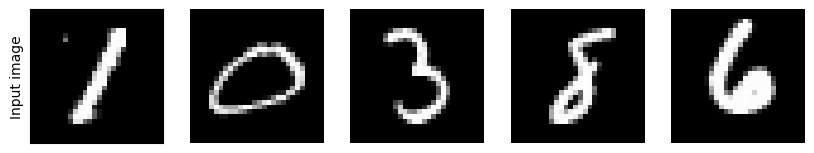

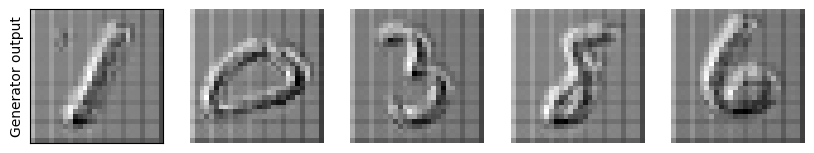

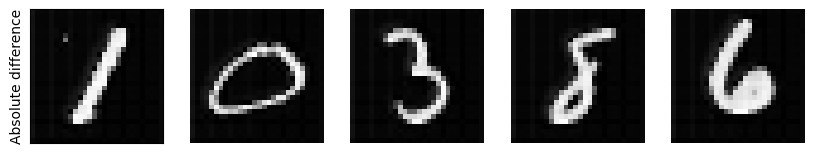

Norm
 tensor([[ 7.9887,  7.6297,  7.8960,  9.0462, 10.7402]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.5045, 0.5046, 0.5046, 0.5045, 0.5046]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[5, 5, 5, 5, 5]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([5, 5, 5, 5, 5], device='cuda:0')

Epoch 1

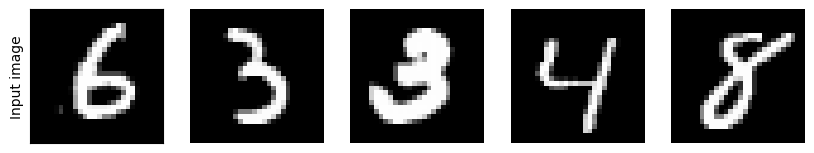

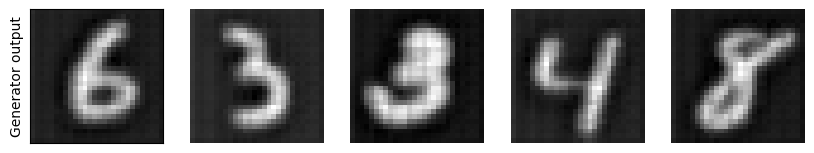

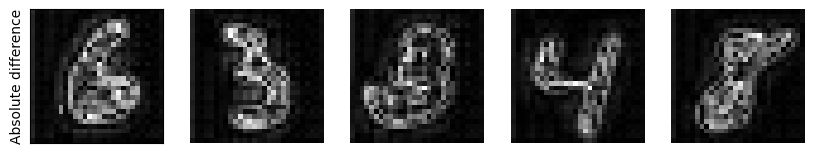

Norm
 tensor([[3.2868, 3.2338, 3.3736, 3.6641, 4.1791]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.5019, 0.5018, 0.5020, 0.5019, 0.5019]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[5, 3, 5, 5, 5]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([5, 3, 3, 5, 3], device='cuda:0')

Epoch 2

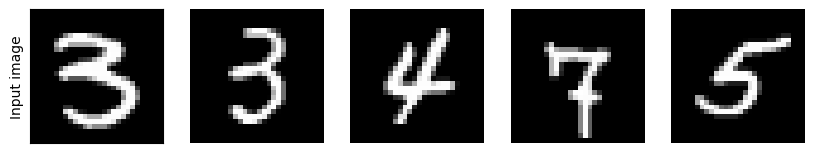

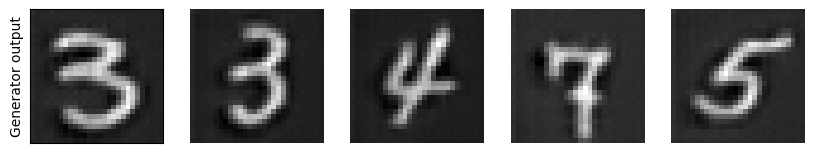

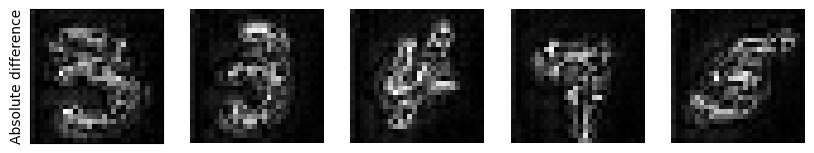

Norm
 tensor([[2.5438, 2.2482, 2.5347, 2.2807, 2.2872]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.4973, 0.4973, 0.4973, 0.4976, 0.4974]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[3, 8, 6, 7, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([3, 3, 6, 7, 8], device='cuda:0')

Epoch 3

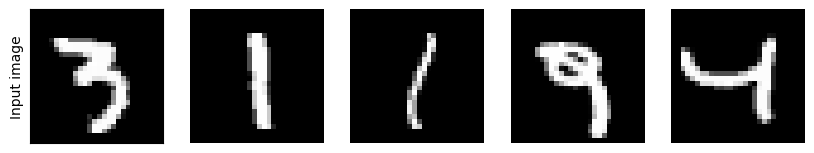

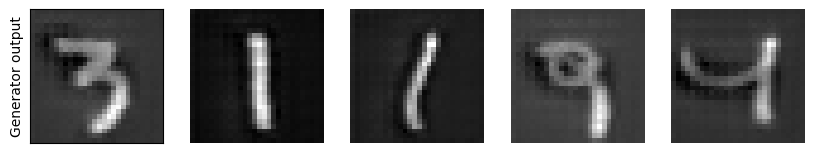

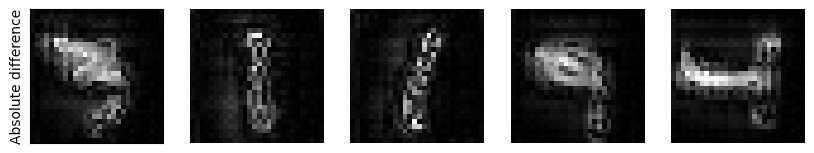

Norm
 tensor([[4.3628, 1.6219, 1.6281, 5.5008, 5.2703]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.4887, 0.4895, 0.4896, 0.4889, 0.4889]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 1, 1, 1, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([7, 1, 1, 9, 9], device='cuda:0')

Epoch 4

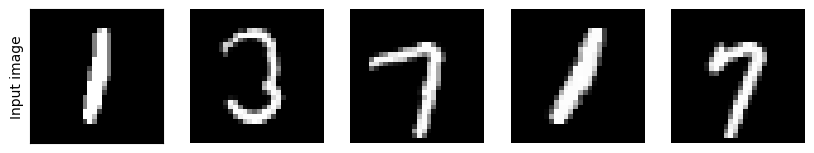

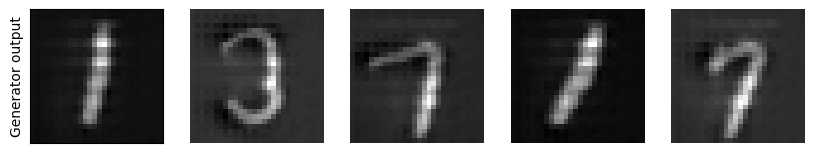

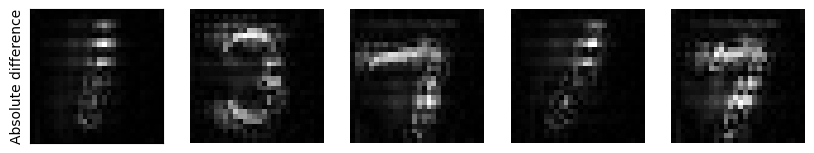

Norm
 tensor([[3.7560, 4.0634, 3.9858, 3.2352, 3.6889]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.4600, 0.4628, 0.4630, 0.4597, 0.4618]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 1, 1, 8, 6]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 3, 7, 1, 7], device='cuda:0')

Epoch 5

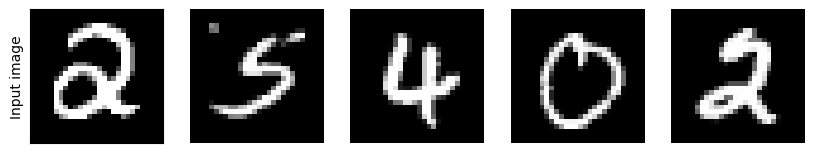

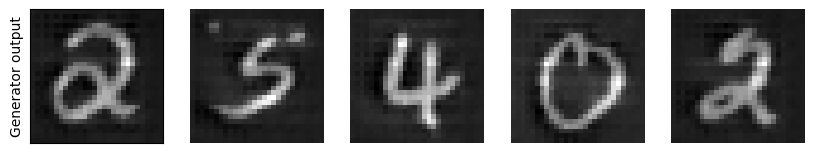

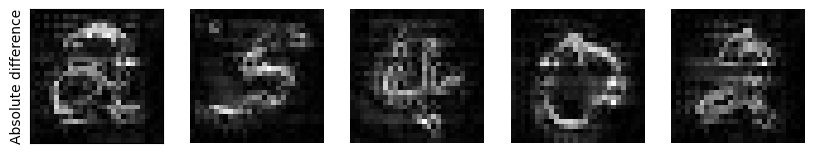

Norm
 tensor([[3.6441, 2.8895, 2.6998, 4.0253, 3.2785]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.3216, 0.3421, 0.3282, 0.3341, 0.3269]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[2, 1, 6, 1, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 5, 4, 3, 3], device='cuda:0')

Epoch 6

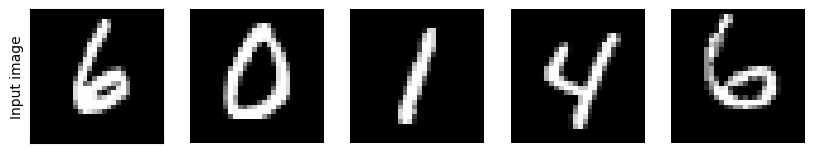

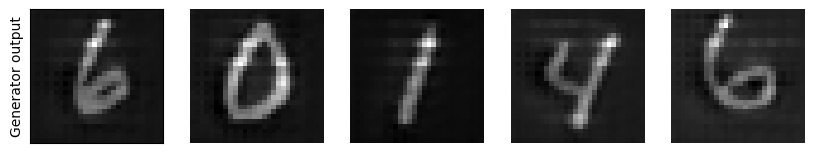

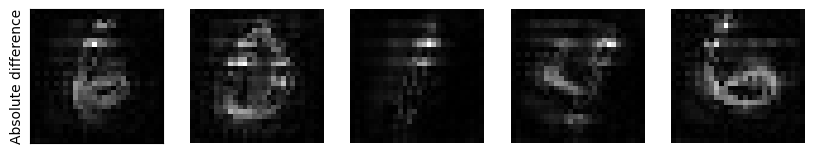

Norm
 tensor([[3.4737, 3.2357, 3.3370, 3.7483, 3.5628]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1409, 0.1179, 0.1410, 0.1369, 0.1594]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 8, 7, 8, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([6, 2, 1, 4, 6], device='cuda:0')

Epoch 7

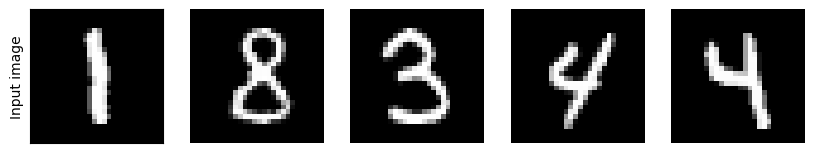

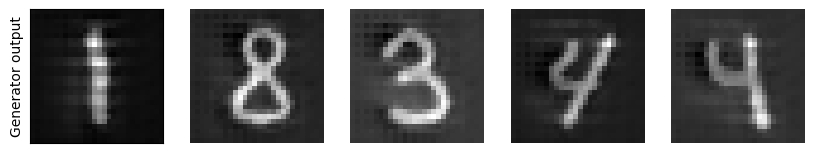

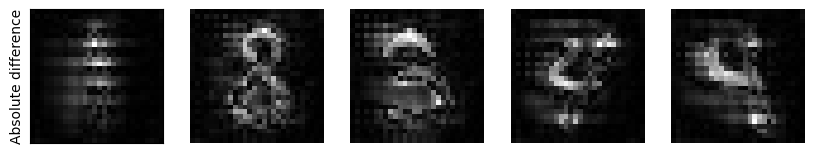

Norm
 tensor([[3.4907, 2.5445, 3.2899, 3.1751, 3.7179]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0667, 0.0704, 0.0746, 0.0688, 0.0753]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 6, 2, 1, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 8, 3, 4, 9], device='cuda:0')

Epoch 8

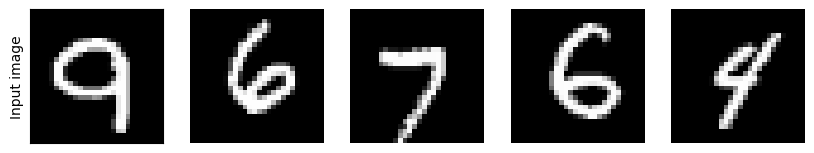

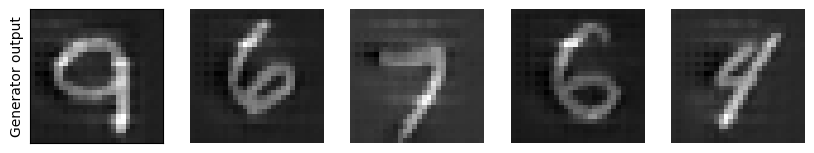

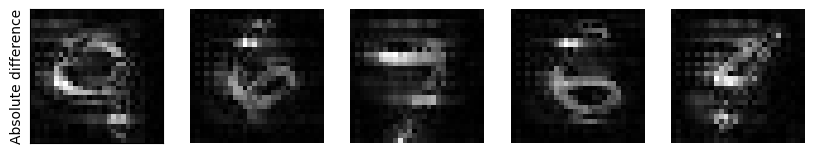

Norm
 tensor([[3.3971, 3.6019, 4.1203, 4.4938, 2.7648]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0357, 0.0320, 0.0481, 0.0356, 0.0436]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[7, 1, 1, 3, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([9, 6, 7, 6, 9], device='cuda:0')

Epoch 9

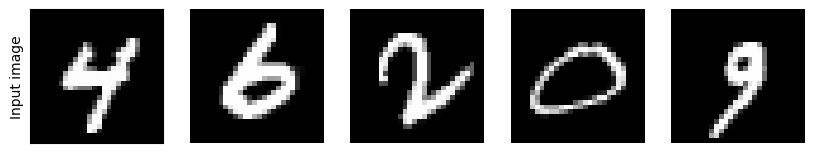

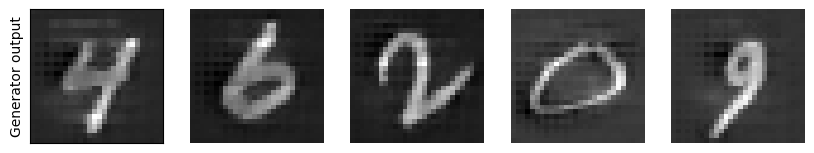

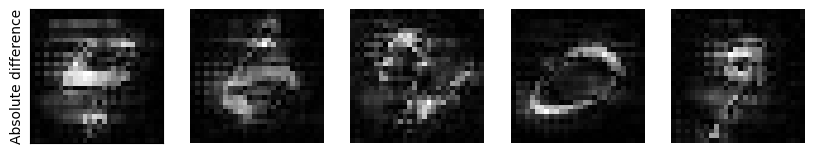

Norm
 tensor([[4.0209, 3.5534, 2.3683, 4.0112, 2.5892]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0253, 0.0196, 0.0199, 0.0412, 0.0294]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 1, 1, 9, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([4, 6, 2, 0, 9], device='cuda:0')

Epoch 10

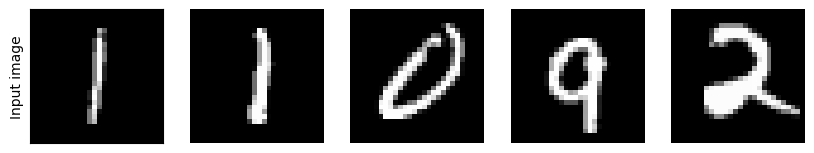

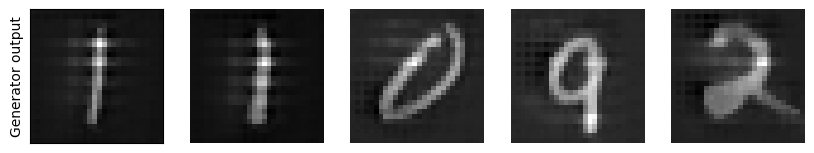

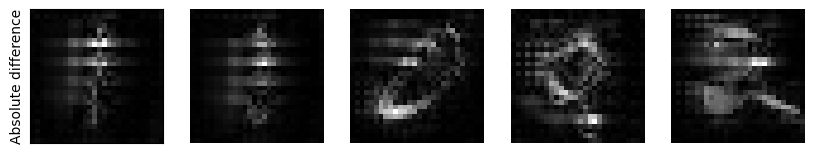

Norm
 tensor([[2.3517, 3.1552, 3.5444, 2.2642, 4.6849]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0338, 0.0201, 0.0145, 0.0161, 0.0136]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[7, 8, 8, 8, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 1, 6, 9, 2], device='cuda:0')

Epoch 11

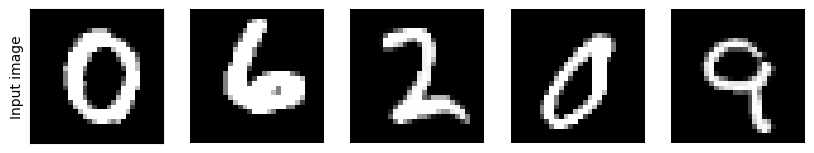

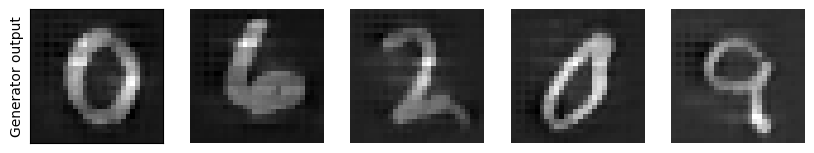

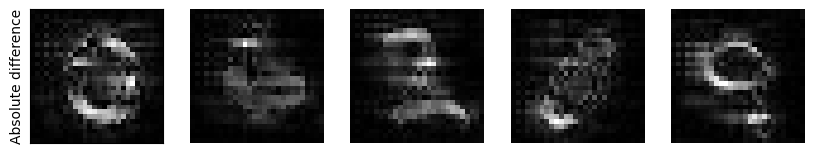

Norm
 tensor([[4.0869, 4.1991, 4.7123, 2.8263, 3.0909]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0079, 0.0090, 0.0126, 0.0096, 0.0212]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 8, 8, 9, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([0, 6, 2, 0, 9], device='cuda:0')

Epoch 12

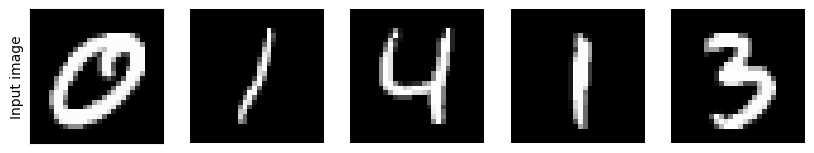

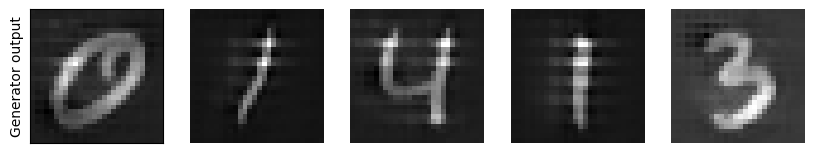

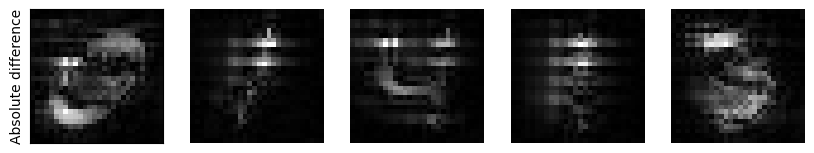

Norm
 tensor([[5.1080, 2.7121, 4.4565, 3.3424, 3.7636]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0054, 0.0198, 0.0094, 0.0147, 0.0096]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 7, 9, 7, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([0, 1, 4, 1, 3], device='cuda:0')

Epoch 13

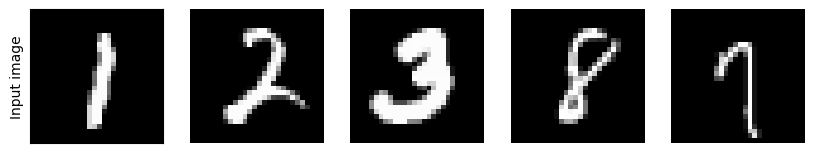

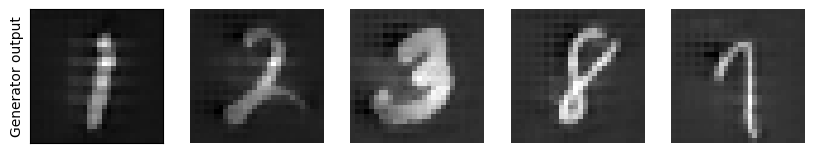

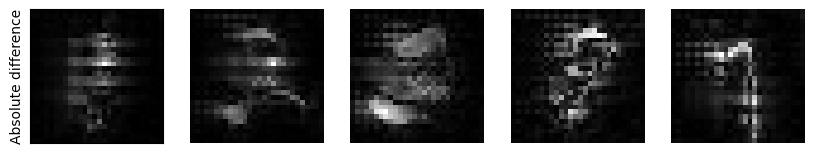

Norm
 tensor([[2.9333, 3.7310, 4.3569, 2.0841, 2.0040]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0142, 0.0122, 0.0080, 0.0152, 0.0258]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 1, 1, 1, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 2, 3, 8, 7], device='cuda:0')

Epoch 14

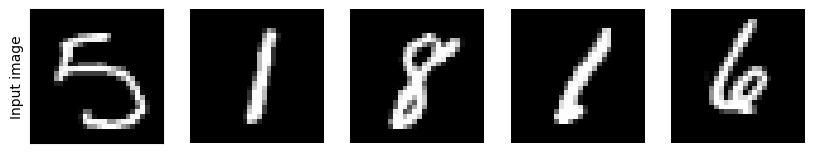

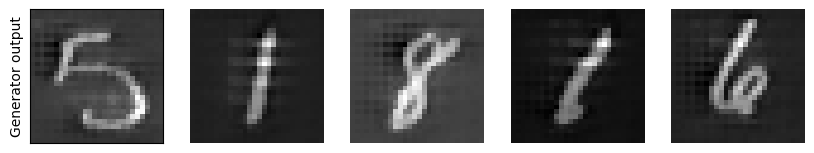

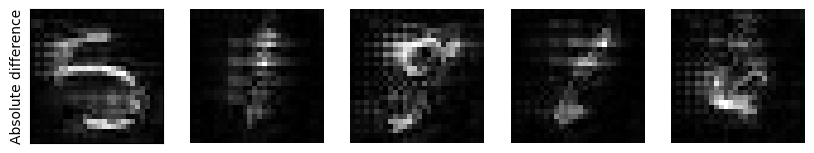

Norm
 tensor([[4.0282, 2.4738, 2.7388, 2.8005, 2.6180]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0264, 0.0205, 0.0182, 0.0176, 0.0160]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[2, 7, 1, 9, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([5, 1, 8, 1, 6], device='cuda:0')

Epoch 15

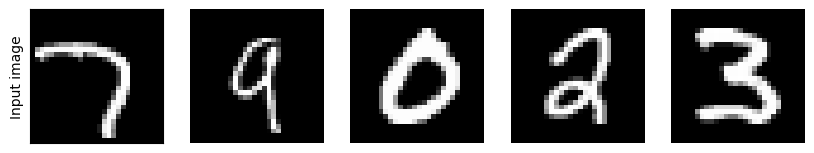

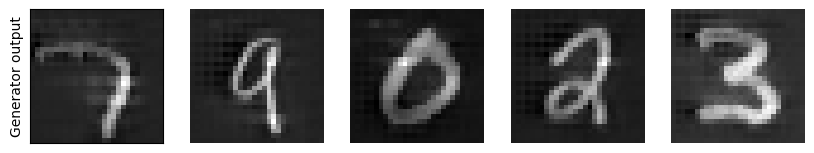

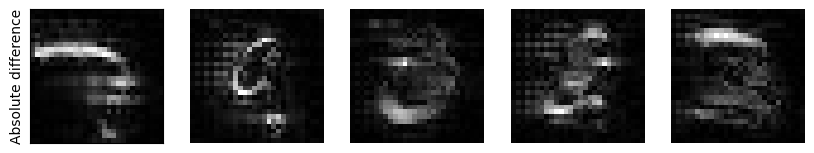

Norm
 tensor([[4.1646, 2.0277, 4.1962, 2.7904, 3.9948]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0378, 0.0404, 0.0204, 0.0279, 0.0259]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 1, 9, 1, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([7, 9, 0, 2, 3], device='cuda:0')

Epoch 16

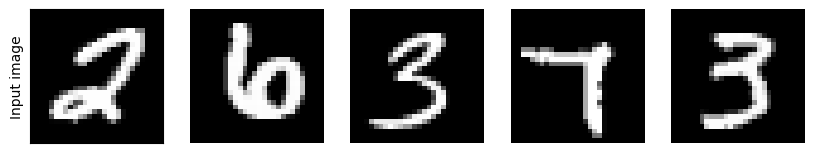

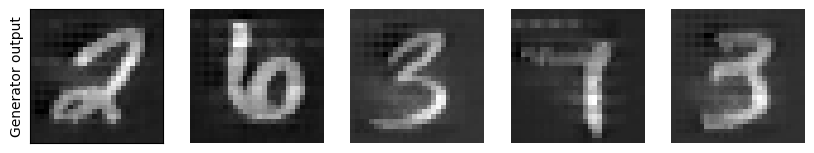

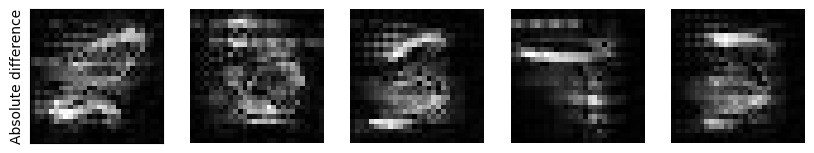

Norm
 tensor([[3.7037, 3.1743, 3.8480, 4.2654, 4.5196]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0851, 0.0709, 0.0966, 0.0845, 0.0883]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 6, 2, 1, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 6, 3, 7, 3], device='cuda:0')

Epoch 17

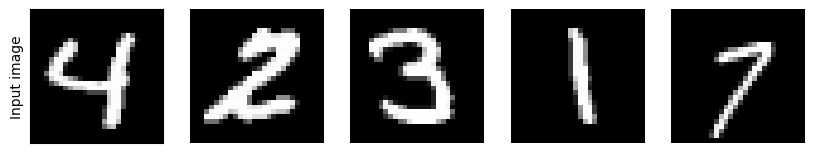

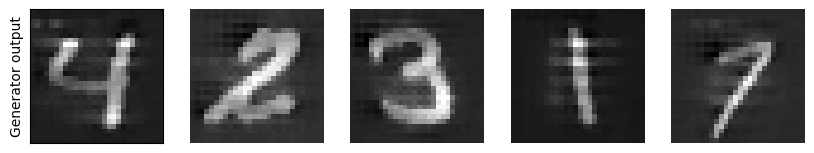

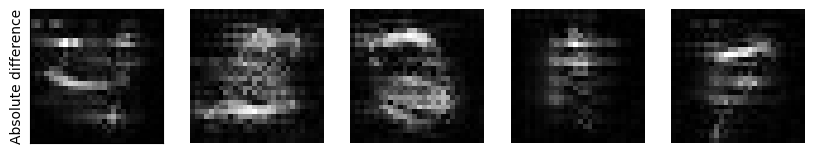

Norm
 tensor([[4.1286, 4.0974, 4.2682, 2.9353, 2.9549]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1253, 0.1993, 0.1048, 0.1754, 0.1607]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 1, 2, 9, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([4, 2, 3, 1, 7], device='cuda:0')

Epoch 18

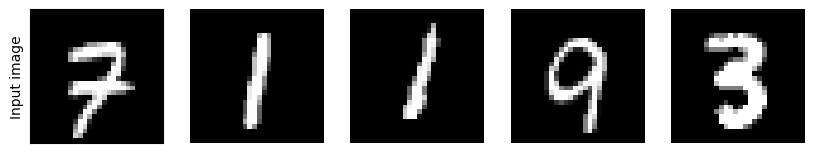

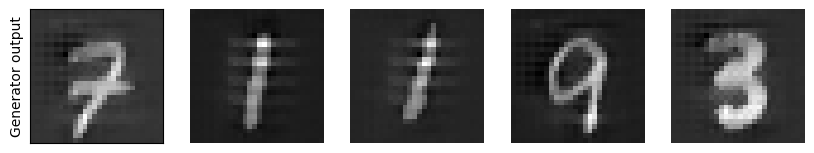

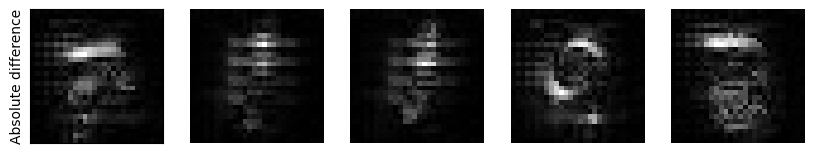

Norm
 tensor([[3.0728, 3.0133, 2.9279, 2.7038, 3.4814]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.2083, 0.2634, 0.2287, 0.1888, 0.2377]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 7, 9, 1, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([7, 1, 1, 9, 3], device='cuda:0')

Epoch 19

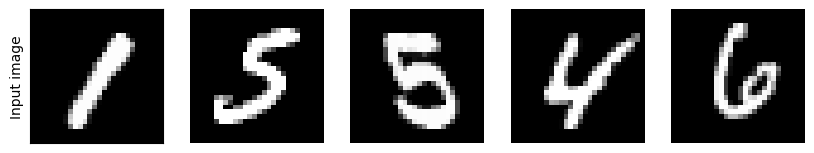

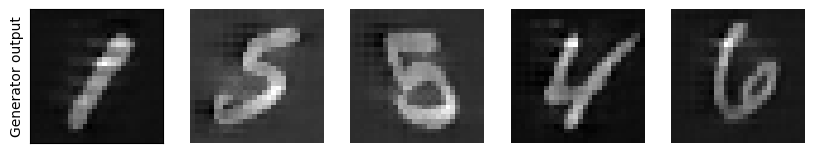

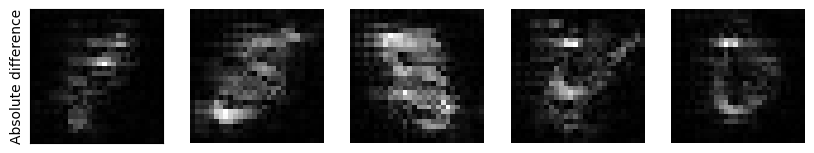

Norm
 tensor([[2.7799, 4.1964, 3.8209, 2.6710, 3.2965]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.3839, 0.2428, 0.1741, 0.2427, 0.1985]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 8, 6, 1, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 5, 8, 4, 6], device='cuda:0')

Epoch 20

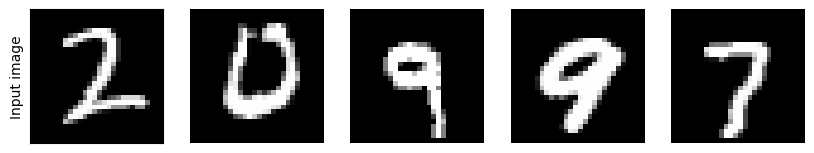

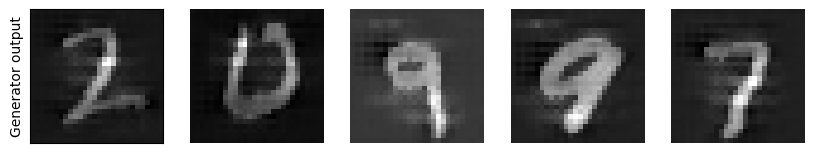

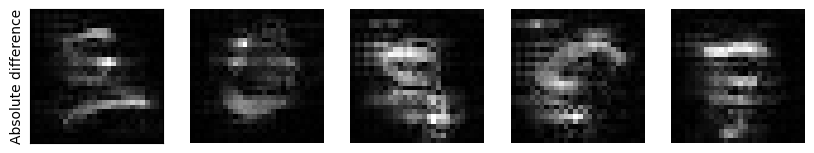

Norm
 tensor([[4.2324, 4.5662, 3.8704, 3.5165, 3.6849]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1030, 0.2454, 0.1309, 0.1404, 0.0626]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 9, 4, 1, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 6, 9, 9, 7], device='cuda:0')

Epoch 21

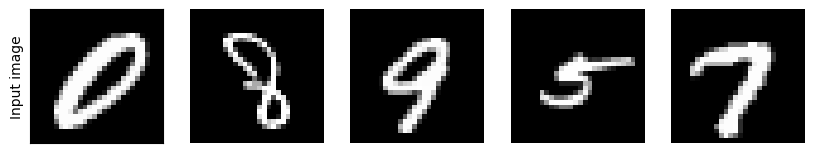

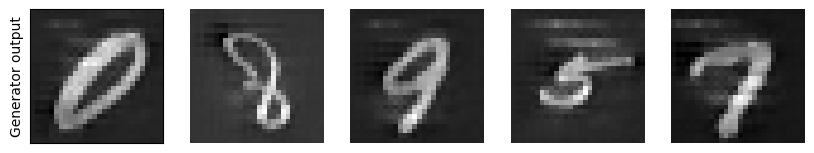

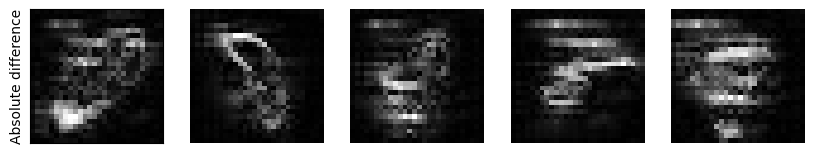

Norm
 tensor([[3.1369, 2.9120, 2.5311, 3.4317, 3.4449]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.3810, 0.0494, 0.1562, 0.0709, 0.0559]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 1, 1, 8, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([0, 8, 9, 5, 7], device='cuda:0')

Epoch 22

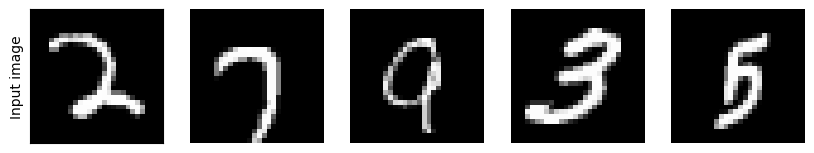

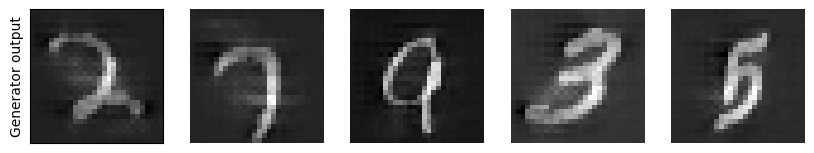

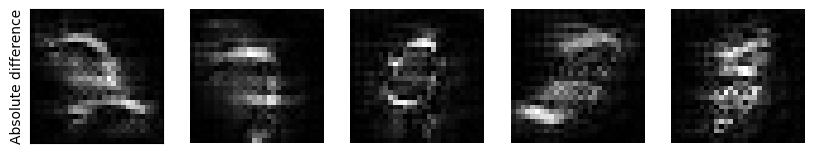

Norm
 tensor([[4.1366, 3.4821, 2.0468, 3.7811, 2.2672]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0220, 0.0588, 0.0861, 0.1705, 0.1701]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 1, 1, 8, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 7, 9, 3, 8], device='cuda:0')

Epoch 23

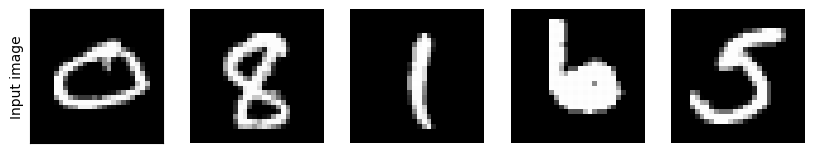

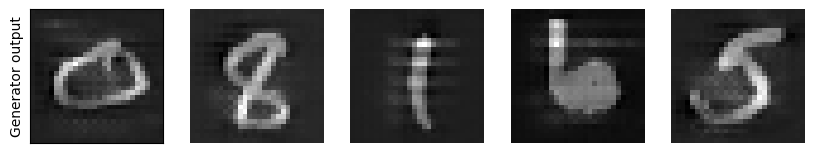

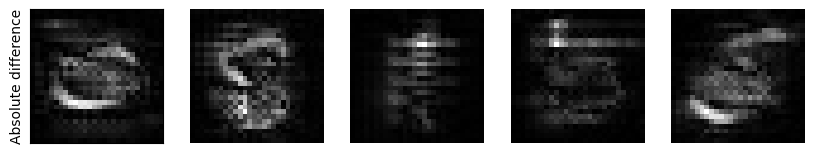

Norm
 tensor([[3.9654, 3.2039, 3.3063, 3.9688, 4.4210]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1887, 0.2540, 0.1259, 0.0541, 0.1091]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 8, 9, 8, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([0, 8, 1, 6, 5], device='cuda:0')

Epoch 24

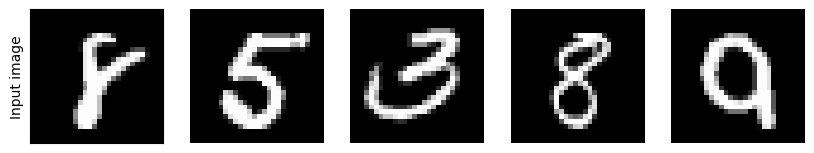

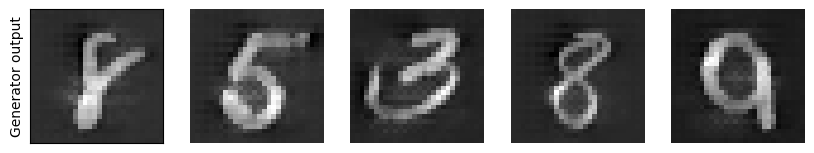

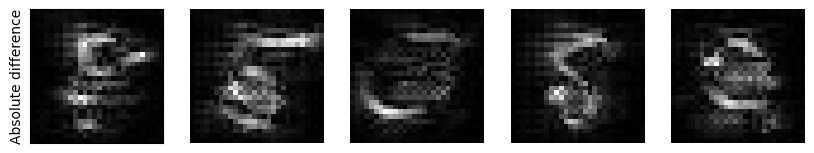

Norm
 tensor([[2.7460, 4.0333, 3.2495, 3.2691, 3.3757]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1960, 0.3293, 0.0736, 0.2750, 0.1776]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[4, 6, 2, 2, 9]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 5, 3, 8, 0], device='cuda:0')

Epoch 25

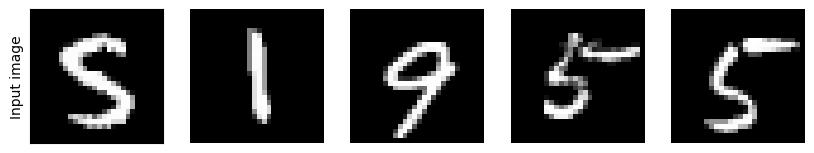

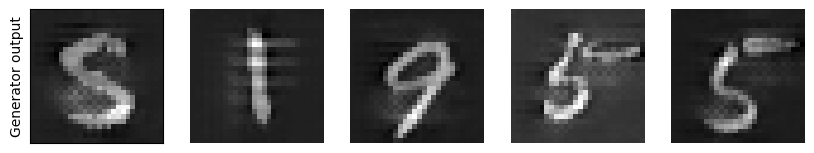

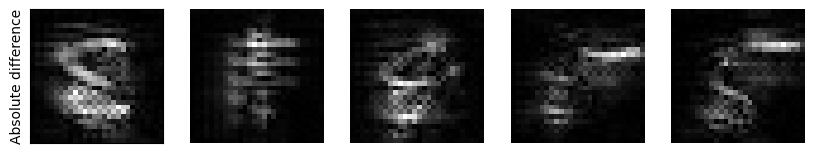

Norm
 tensor([[4.1314, 2.5815, 2.8682, 2.9424, 3.1486]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.1625, 0.0559, 0.1175, 0.1126, 0.2218]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[6, 9, 8, 0, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([5, 1, 9, 5, 5], device='cuda:0')

Epoch 26

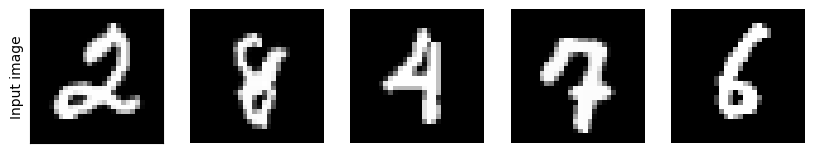

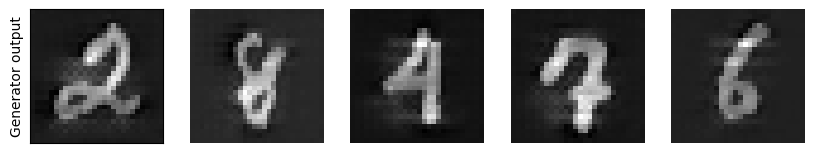

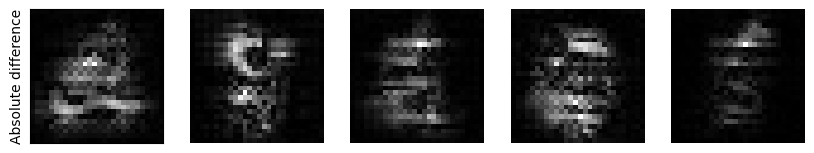

Norm
 tensor([[3.7892, 2.3529, 2.8896, 2.5293, 2.9420]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0837, 0.1071, 0.1368, 0.0913, 0.4475]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 1, 8, 1, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 8, 4, 9, 6], device='cuda:0')

Epoch 27

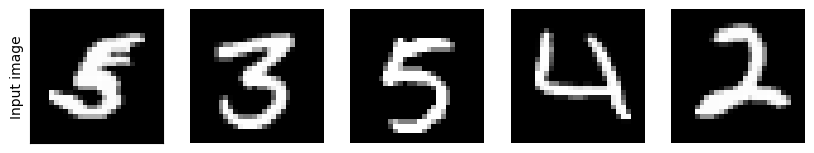

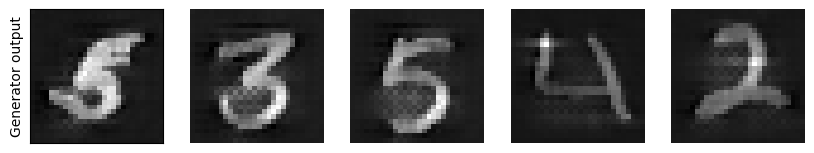

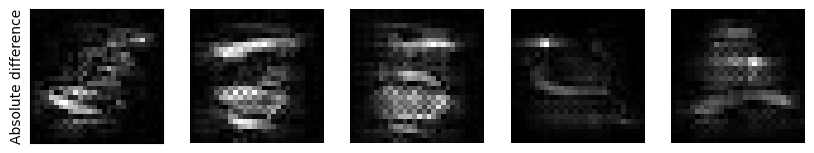

Norm
 tensor([[2.7266, 4.2154, 4.0226, 4.3072, 4.3406]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0759, 0.0181, 0.0875, 0.1522, 0.0384]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 2, 8, 7, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([5, 3, 5, 4, 2], device='cuda:0')

Epoch 28

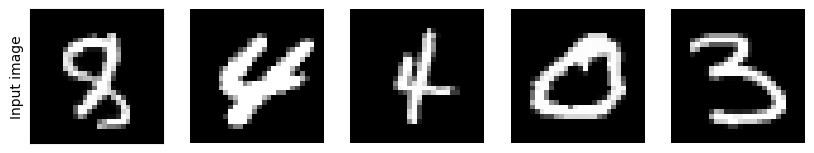

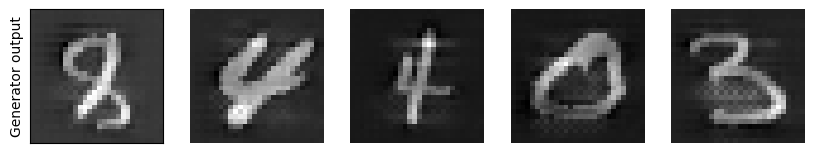

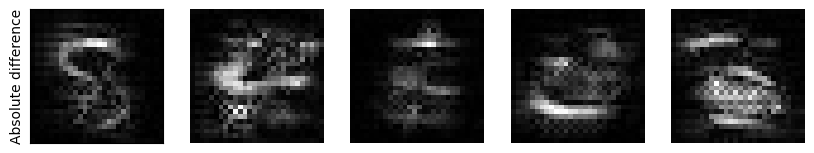

Norm
 tensor([[3.0355, 2.9261, 2.7214, 4.6575, 4.0491]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0358, 0.0454, 0.0806, 0.2105, 0.0116]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[1, 0, 8, 9, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 4, 4, 0, 3], device='cuda:0')

Epoch 29

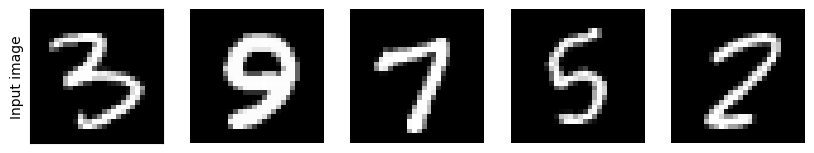

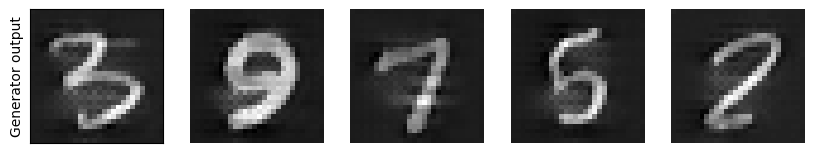

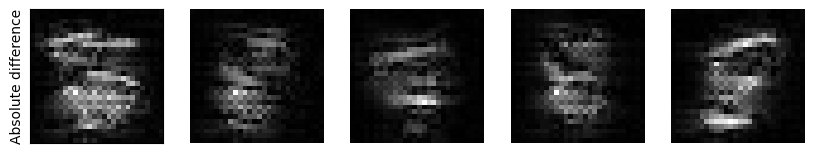

Norm
 tensor([[3.2264, 3.0280, 3.4132, 2.8837, 3.3030]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 1 guess
 tensor([[0.0441, 0.0640, 0.0320, 0.4548, 0.0584]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 8, 8, 8, 1]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([3, 8, 7, 5, 2], device='cuda:0')

In [12]:
trainer = dl.Trainer(max_epochs=30)
trainer.fit(gan, train_loader)

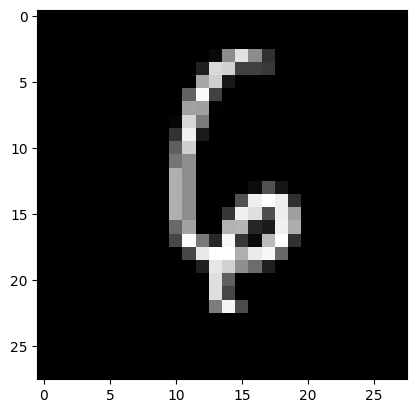

NameError: name 'test_output' is not defined

In [10]:
dtest_output = gan.generator(list(test_loader)[99][0])

plt.imshow(tensor_to_image(list(test_loader)[99][0][0]),cmap="gray")
plt.show()
plt.imshow(tensor_to_image(test_output[0]),cmap="gray")
plt.show()

In [ ]:
trainer.history.plot()